# <a>Prévision du cout de l'énergie

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!pip3 uninstall matplotlib

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? Y
  Successfully uninstalled matplotlib-3.5.3


In [7]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [4]:
!pip3 install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 14.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [5]:
!pip3 install --upgrade darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 14.6 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 1.8 MB 67.7 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.5 MB/s 
     |████████████████████████████████| 11.2 MB 45.4 MB/s 
     |████████████████████████████████| 798 kB 56.2 MB/s 
     |████████████████████████████████| 569 kB 51.2 MB/s 
     |████████████████████████████████| 1.6 MB 33.2 MB/s 
     |████████████████████████████████| 965 kB 48.6 MB/s 
     |████████████████████████████████| 125 kB 53.1 MB/s 
     |████████████████████████████████| 529 kB 55.7 MB/s 
     |████████████████████████████████| 87 kB 7.7 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=2c812d37213d23f329f74407dd2aaacf69d8ff2286db788cbb0b4065e2390635
 

In [8]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _png
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
from typing import List, Tuple, Dict
from darts import TimeSeries
import random
import torch
import time
from darts.utils.losses import SmapeLoss
from darts.models import FFT, ExponentialSmoothing, Theta,NBEATSModel,TCNModel
from darts.metrics import mae,rmse
from darts.utils.missing_values import fill_missing_values
from darts.datasets import EnergyDataset
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import logging
logging.disable(logging.CRITICAL)

In [9]:
def plot_models_result(method_to_elapsed_times, method_to_smapes):
    shapes = ["o", "s", "*"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    styles = list(product(shapes, colors))

    plt.figure(figsize=(6, 6), dpi=100)
    for i, method in enumerate(method_to_elapsed_times.keys()):
        t = method_to_elapsed_times[method]
        s = styles[i]
        plt.semilogx(
            [t],
            [(method_to_smapes[method])],
            s[0],
            color=s[1],
            label=method,
            markersize=13,
        )
    plt.xlabel("elapsed time [s]")
    plt.ylabel("rmse")
    plt.legend(bbox_to_anchor=(1.4, 1.0), frameon=True);

In [10]:
def plot_model(dtf,rmse):
  series = fill_missing_values(
    TimeSeries.from_dataframe( dtf))
  plt.figure(figsize=(10,6))
  train_inv.plot(label='train')
  test_inv.plot(label='test')
  series['Predictions'].plot(label='prediction')
  plt.title("RMSE: %.3f" %rmse)

In [11]:
path="/content/gdrive/MyDrive/Projet7/datasets/energy_dataset.csv"

df=pd.read_csv(path)

In [ ]:
df.head()

time  generation biomass  \
0  2014-12-31 23:00:00               447.0   
1  2015-01-01 00:00:00               449.0   
2  2015-01-01 01:00:00               448.0   
3  2015-01-01 02:00:00               438.0   
4  2015-01-01 03:00:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [73]:
df.shape

(35064, 29)

<AxesSubplot:>

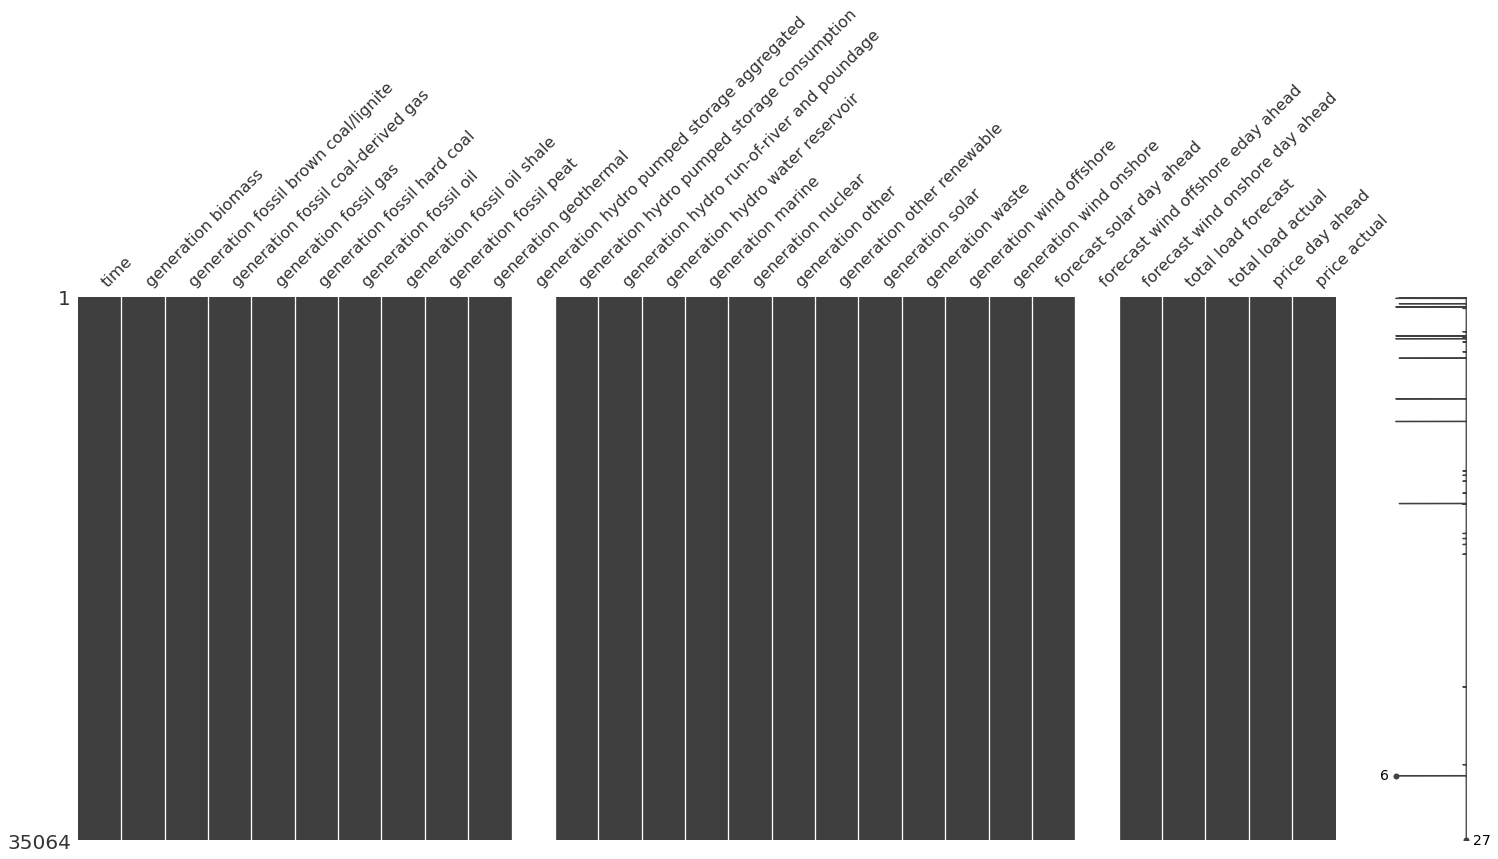

In [ ]:
import missingno as mno

mno.matrix(df)
    


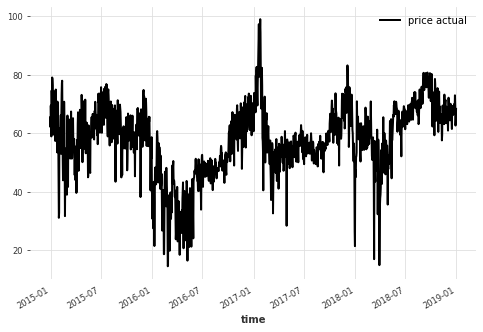

In [12]:
dat = df.set_index(['time'])
df3=dat.copy()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["price actual"]
    ),
    "auto",
)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)
# add the month as a covariate
month_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="month", one_hot=True
)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)
train_moth, val_month = month_series.split_after(pd.Timestamp("20170901"))

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)

scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

plt.figure(figsize=(8, 5))
series_en.plot()

Text(0.5, 1.0, 'Train Test Split')

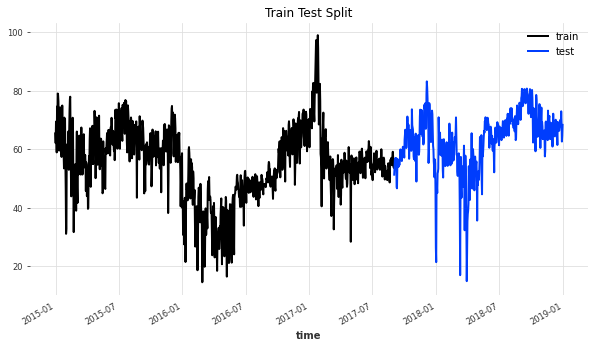

In [13]:
train_inv=scaler_en.inverse_transform(train_en_transformed)
test_inv=scaler_en.inverse_transform(val_en_transformed)
plt.figure(figsize=(10, 5))
train_inv.plot(label='train')
test_inv.plot(label='test')
plt.title("Train Test Split")

In [14]:
train=train_inv.pd_dataframe()
test=test_inv.pd_dataframe()

## I-Forecasting using classic models

## 1-Auto ARIMA

Habituellement, dans le modèle ARIMA de base, nous devons fournir les valeurs p, d et q qui sont essentielles. Nous utilisons des techniques statistiques pour générer ces valeurs en effectuant la différence pour éliminer la non-stationnarité et en traçant les graphiques ACF et PACF.Dans Auto ARIMA, le modèle lui-même générera les valeurs p, d et q optimales qui conviendraient à l'ensemble de données pour fournir une meilleure prévision.

In [15]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from pmdarima.arima import auto_arima
start_time = time.time()
arima_model=auto_arima(train,start_p=2, start_q=2,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=None,          
                      seasonal=True,   
                      start_P=1, 
                      D=None, 
                      trace=True,
                       method='lbfgs',
                      error_action='ignore',
                       n_fits = 50,  
                      suppress_warnings=True, 
                      stepwise=True)
aarima_elapsed_time = time.time() - start_time

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6192.094, Time=1.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7667.521, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6348.456, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6875.051, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10648.821, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6191.121, Time=1.53 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6631.431, Time=0.94 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6349.040, Time=0.78 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6191.971, Time=2.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=6565.876, Time=1.69 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6326.305, Time=2.02 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6194.032, Time=4.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6198.497, Time=0.67 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 16.677 seconds


In [17]:
#Summary of the model
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  976
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -3090.560
Date:                Sat, 26 Nov 2022   AIC                           6191.121
Time:                        19:56:42   BIC                           6215.538
Sample:                    12-31-2014   HQIC                          6200.412
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7172      0.282      2.540      0.011       0.164       1.271
ar.L1          0.9872      0.005    203.591      0.000       0.978       0.997
ma.L1         -0.2624      0.025    -10.483      0.0

In [18]:
predictions_aarima = arima_model.predict(n_periods=test["price actual"].size, \
                                        X=None, \
                                        return_conf_int=False, \
                                        alpha=0.05)
predictions_aarima.name = "Predictions"
result_aarima  = pd.concat([test, predictions_aarima], axis=1).reindex(test.index)
result_aarima


price actual  Predictions
time                                 
2017-09-02     51.300417    54.989418
2017-09-03     53.528333    55.386461
2017-09-04     56.404167    55.394372
2017-09-05     56.906667    55.402182
2017-09-06     54.146250    55.409892
...                  ...          ...
2018-12-27     72.959583    56.002995
2018-12-28     69.230417    56.003011
2018-12-29     62.623333    56.003027
2018-12-30     64.567083    56.003043
2018-12-31     68.318696    56.003059

[486 rows x 2 columns]

In [ ]:
results=pd.DataFrame()
rmse_aarima = sqrt(mean_squared_error(test["price actual"], \
                                      predictions_aarima))
print("SARIMA - Root Mean Square Error (RMSE): %.3f" % rmse_aarima)

SARIMA - Root Mean Square Error (RMSE): 12.075


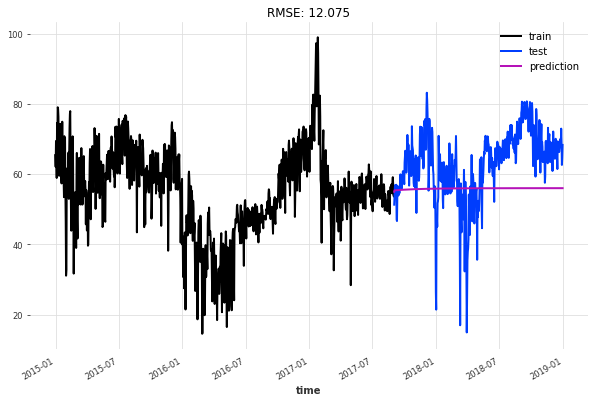

In [ ]:
results=results.append(pd.DataFrame({'Modèle' : ['AUTO_ARIMA '],
    'RMSE':[rmse_aarima],'Training_time':[aarima_elapsed_time]}),ignore_index=True)
#Plotting the predictions w.r.t. test values
plot_model(result_aarima,rmse_aarima)

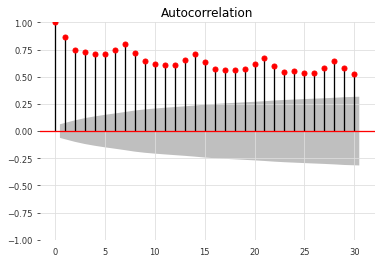

In [25]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train,color='red')
pyplot.show()

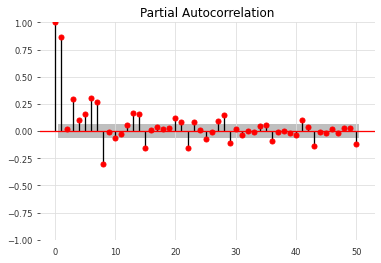

In [26]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags=50,color='red')
pyplot.show()

## 8-Facebook Prophet

Facebook, ont publié un modèle étonnant appelé Facebook Prophet. Prophet permet à presque tout le monde de prédire les valeurs de séries chronologiques, même si vous avez très peu ou pas d'expérience dans ce domaine. Dans la plupart des cas, cela fonctionne correctement et votre analyste de données sera en mesure de raconter des histoires assez précises avec la sortie. Mais, certains paramètres nécessitent un réglage car nous utiliserons une simple trame de données y et ds (le format utilisé par Prophet). 



In [27]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 1.2 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638847 sha256=fd97b7d7786b3558d8882aafd80f438c90b90d96a2c10a32de74f5395b7186be
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the 

In [28]:
!pip install prophet

import prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 6.9 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.8 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [29]:
from fbprophet import Prophet
# instantiate the model and set parameters
start_time=time.time()
model_fb = Prophet( \
                   interval_width = 0.95, \
                   growth = "linear", \
                   daily_seasonality = False, \
                   weekly_seasonality = False, \
                   yearly_seasonality = False, \
                   
)
train_fb = train.reset_index().copy()
train_fb.columns = ["ds","y"]
# fit the model to historical data
model_fb.fit(train_fb)
fb_elapsed_time=time.time()-start_time

In [45]:
future_pd = model_fb.make_future_dataframe(periods=486, freq='d',include_history=True)
# predict over the dataset
predictions_fb = model_fb.predict(future_pd)
predictions_fb

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2014-12-31  58.752551   43.679606   74.707453    58.752551    58.752551   
1    2015-01-01  58.777964   42.368612   74.215073    58.777964    58.777964   
2    2015-01-02  58.803377   42.483172   74.488369    58.803377    58.803377   
3    2015-01-03  58.828790   41.220743   75.590538    58.828790    58.828790   
4    2015-01-04  58.854202   42.441987   75.201321    58.854202    58.854202   
...         ...        ...         ...         ...          ...          ...   
1457 2018-12-27  22.732003  -47.522892   99.513970   -46.012956    95.518536   
1458 2018-12-28  22.673828  -50.298735   99.022649   -46.274598    95.624855   
1459 2018-12-29  22.615653  -49.621871   99.745268   -46.536240    95.731174   
1460 2018-12-30  22.557477  -47.236380   95.849594   -46.797881    95.837492   
1461 2018-12-31  22.499302  -50.696995   99.031910   -47.059523    95.943811   

      additive_terms  additive_terms_lower  additive_terms_upper  \
0                0.0                   0.0                   0.0   
1                0.0                   0.0                   0.0   
2                0.0                   0.0                   0.0   
3                0.0                   0.0                   0.0   
4                0.0                   0.0                   0.0   
...              ...                   ...                   ...   
1457             0.0                   0.0                   0.0   
1458             0.0                   0.0                   0.0   
1459             0.0                   0.0                   0.0   
1460             0.0                   0.0                   0.0   
1461             0.0                   0.0                   0.0   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
1457                   0.0                         0.0   
1458                   0.0                         0.0   
1459                   0.0                         0.0   
1460                   0.0                         0.0   
1461                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
0                            0.0  58.752551  
1                            0.0  58.777964  
2                            0.0  58.803377  
3                            0.0  58.828790  
4                            0.0  58.854202  
...                          ...        ...  
1457                         0.0  22.732003  
1458                         0.0  22.673828  
1459                         0.0  22.615653  
1460                         0.0  22.557477  
1461                         0.0  22.499302  

[1462 rows x 13 columns]

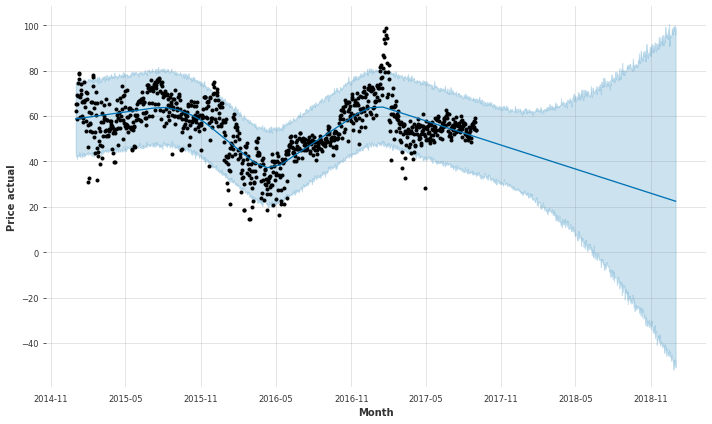

In [46]:
predict_fig = model_fb.plot(predictions_fb, \
                            xlabel='Month', \
                            ylabel='Price actual')

In [47]:
result_fb=predictions_fb.loc[predictions_fb['ds'].isin(test.reset_index('time').time.tolist()),:]
result_fb=result_fb.iloc[:,[0,-1]].rename(columns={'ds':'time','yhat':'Predictions'}).set_index('time')
result_fb

Predictions
time                   
2017-09-02    50.714314
2017-09-03    50.656139
2017-09-04    50.597963
2017-09-05    50.539788
2017-09-06    50.481613
...                 ...
2018-12-27    22.732003
2018-12-28    22.673828
2018-12-29    22.615653
2018-12-30    22.557477
2018-12-31    22.499302

[486 rows x 1 columns]

In [ ]:
rmse_fb = sqrt(mean_squared_error(test, result_fb['Predictions']))
print("FPROPHET- Root Mean Square Error (RMSE): %.3f" % rmse_fb)


FPROPHET- Root Mean Square Error (RMSE): 30.507


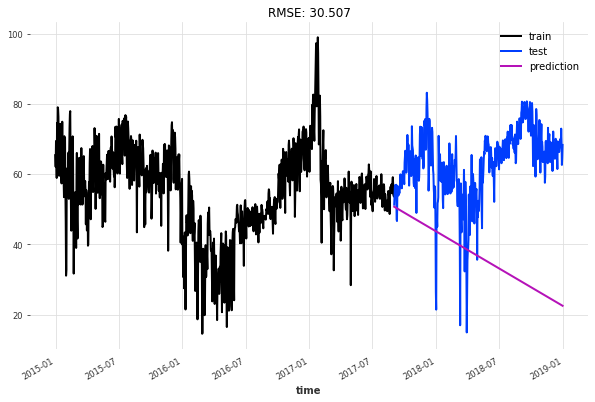

In [ ]:
results=results.append(pd.DataFrame({'Modèle' : ['FPROPHET'],
    'RMSE':[rmse_fb],'Training_time':[fb_elapsed_time]}),ignore_index=True)
#Plotting the predictions w.r.t. test values
plot_model(result_fb,rmse_fb)

##  XGBoost

XGBoost (E x treme G radient B oosting) est une implémentation de gradient boosting pour les problèmes de classification et de régression. Cela peut être utilisé pour la prévision de séries chronologiques en restructurant l'ensemble de données d'entrée pour ressembler à un problème d'apprentissage supervisé.

In [74]:
from sklearn.model_selection import train_test_split 
import xgboost 
dataXGB =series_en.pd_dataframe().reset_index(['time']).copy() 
# Restructurer les données 
dataXGB["Target"] = dataXGB['price actual'].shift(-1)
# Supprimer la dernière colonne nulle en raison du décalage 
dataXGB.dropna(inplace=True)
# Extraire les caractéristiques et les étiquettes 
X = dataXGB.iloc[:,1:2].values 
y= dataXGB.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,
                       random_state = 0, shuffle=False)
start_time=time.time()
reg = xgboost.XGBRegressor(objective='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train)
xgb_elapsed_time=time.time()-start_time

In [75]:
predictions_xgb = reg.predict(X_test)
predictions_xgb = pd.DataFrame({'Predictions': predictions_xgb})
result_xgb = pd.concat( [dataXGB.tail(len(X_test)).reset_index(drop=True),predictions_xgb], axis=1)
print (result_xgb)

          time  price actual     Target  Predictions
0   2017-09-04     56.404167  56.906667    56.675613
1   2017-09-05     56.906667  54.146250    60.622509
2   2017-09-06     54.146250  55.586250    59.894432
3   2017-09-07     55.586250  56.970000    51.524830
4   2017-09-08     56.970000  47.089583    57.997177
..         ...           ...        ...          ...
478 2018-12-26     69.054167  72.959583    69.707413
479 2018-12-27     72.959583  69.230417    70.317970
480 2018-12-28     69.230417  62.623333    69.707413
481 2018-12-29     62.623333  64.567083    58.540409
482 2018-12-30     64.567083  68.318696    64.915245

[483 rows x 4 columns]


In [ ]:
rmse_xgb = sqrt(mean_squared_error(y_test, \
                                      predictions_xgb))
print("Xgboost- Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

Xgboost- Root Mean Square Error (RMSE): 6.417


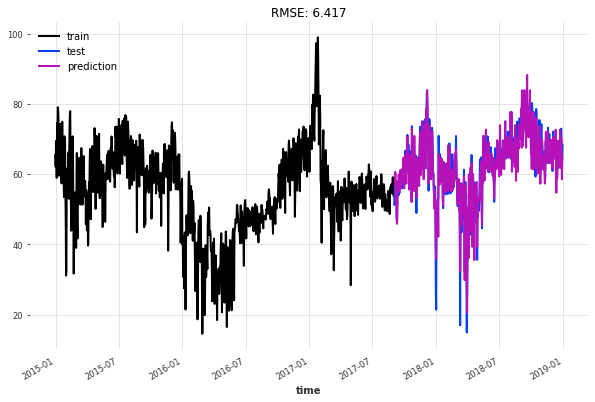

In [ ]:
results=results.append(pd.DataFrame({'Modèle' : ['XGBoost'],
  'RMSE':[rmse_xgb],'Training_time':[xgb_elapsed_time]}),ignore_index=True)
#Plotting the predictions w.r.t. test values
result_xgb=result_xgb.loc[:,['time','price actual','Predictions']].set_index(['time'])
plot_model(result_xgb,rmse_xgb)

## TBAT

BATS et TBATS sont des algorithmes de prévision de séries chronologiques et fonctionnent bien avec plusieurs périodes saisonnières. Le TBATS est préféré lorsque la saisonnalité est complexe. TBATS est l'acronyme de :

- Saisonnalité trigonométrique
- Transformation de Box-Cox
- Une erreur RMSE
- Tendance _
- Composantes saisonnières

In [78]:
from tbats import TBATS 
# /databricks/python/bin/pip install tbats==1.1.0
start_time=time.time()
model_tbats = TBATS(seasonal_periods=(12, 24),
              use_arma_errors=False,
              use_box_cox=False, 
              n_jobs=1,
              use_trend=None,
              use_damped_trend=None).fit(train['price actual'])
tbats_elapsed_time=time.time()-start_time

In [80]:
print(model_tbats.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [12. 24.]
Seasonal harmonics [1 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.890956
Trend (Beta): -0.179905
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-3.91987378e-07 -2.61781099e-07 -8.26075450e-08  1.89364496e-07]
AR coefficients []
MA coefficients []
Seed vector [ 6.32507639e+01  1.88851266e+00 -2.91079069e-01  4.64400536e-02
 -3.74839625e-01  3.69085773e-01]

AIC 10269.063335


In [ ]:
predictions_tbats = model_tbats.forecast(steps=486)
predictions_tbatsDF = pd.DataFrame()
predictions_tbatsDF["Predictions"] = predictions_tbats.tolist()
result_tbats = pd.concat([test.reset_index(),
                           predictions_tbatsDF], axis=1)
print (result_tbats)

          time  price actual  Predictions
0   2017-09-02     51.300417    53.915417
1   2017-09-03     53.528333    54.001456
2   2017-09-04     56.404167    54.006658
3   2017-09-05     56.906667    53.939215
4   2017-09-06     54.146250    53.825512
..         ...           ...          ...
481 2018-12-27     72.959583    54.496539
482 2018-12-28     69.230417    54.402725
483 2018-12-29     62.623333    54.256068
484 2018-12-30     64.567083    54.078995
485 2018-12-31     68.318696    53.908255

[486 rows x 3 columns]


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_tbats = sqrt(mean_squared_error(test["price actual"], \
                                      predictions_tbatsDF))
print("TBATS - Root Mean Square Error (RMSE): %.3f" % rmse_tbats)

TBATS - Root Mean Square Error (RMSE): 13.031


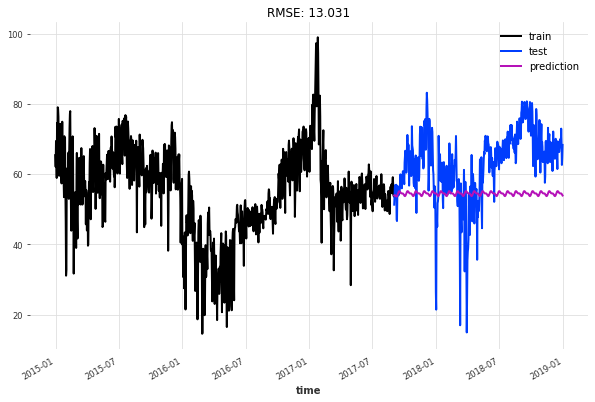

In [ ]:
results=results.append(pd.DataFrame({'Modèle' : ['TBATS'],
   'RMSE':[rmse_tbats],'Training_time':[tbats_elapsed_time]}),ignore_index=True)
#Plotting the predictions w.r.t. test values
result_tbats=result_tbats.set_index(['time'])
plot_model(result_tbats,rmse_tbats)

## II-Forecasting using new models

### 1-Nbeats

NBEATS, une architecture de réseau de neurones pour la prévision de séries temporelles.
NBEATS est issu des recherches de Boris Oreshkin et de ses co-auteurs chez ElementAI, malheureusement de courte durée. NBEATS est une étape intéressante dans l'application de l'apprentissage en profondeur aux séries chronologiques, car il crée une architecture dédiée aux séries chronologiques.NBEATS utilise une approche complètement différente : il prend une fenêtre entière de valeurs passées et calcule de nombreuses valeurs de points de temps de prévision en une seule passe. Pour ce faire, il utilise largement des couches entièrement connectées.

In [ ]:
start_time = time.time()

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)
model_nbeats.fit(series=train_en_transformed, val_series=val_en_transformed, verbose=True)
nbeats_elapsed_time = time.time() - start_time

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series_en_transformed,
    start=pd.Timestamp("20170901"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/97 [00:00<?, ?it/s]

Predicting: 2it [00:00, ?it/s]

  1%|          | 1/97 [00:00<00:14,  6.44it/s]

Predicting: 2it [00:00, ?it/s]

  2%|▏         | 2/97 [00:00<00:14,  6.63it/s]

Predicting: 2it [00:00, ?it/s]

  3%|▎         | 3/97 [00:00<00:13,  7.06it/s]

Predicting: 2it [00:00, ?it/s]

  4%|▍         | 4/97 [00:00<00:12,  7.34it/s]

Predicting: 2it [00:00, ?it/s]

  5%|▌         | 5/97 [00:00<00:12,  7.54it/s]

Predicting: 2it [00:00, ?it/s]

  6%|▌         | 6/97 [00:00<00:12,  7.16it/s]

Predicting: 2it [00:00, ?it/s]

  7%|▋         | 7/97 [00:01<00:13,  6.82it/s]

Predicting: 2it [00:00, ?it/s]

  8%|▊         | 8/97 [00:01<00:12,  7.03it/s]

Predicting: 2it [00:00, ?it/s]

  9%|▉         | 9/97 [00:01<00:12,  7.22it/s]

Predicting: 2it [00:00, ?it/s]

 10%|█         | 10/97 [00:01<00:11,  7.30it/s]

Predicting: 2it [00:00, ?it/s]

 11%|█▏        | 11/97 [00:01<00:11,  7.17it/s]

Predicting: 2it [00:00, ?it/s]

 12%|█▏        | 12/97 [00:01<00:12,  6.98it/s]

Predicting: 2it [00:00, ?it/s]

 13%|█▎        | 13/97 [00:01<00:12,  6.74it/s]

Predicting: 2it [00:00, ?it/s]

 14%|█▍        | 14/97 [00:02<00:12,  6.67it/s]

Predicting: 2it [00:00, ?it/s]

 15%|█▌        | 15/97 [00:02<00:12,  6.75it/s]

Predicting: 2it [00:00, ?it/s]

 16%|█▋        | 16/97 [00:02<00:11,  7.17it/s]

Predicting: 2it [00:00, ?it/s]

 18%|█▊        | 17/97 [00:02<00:11,  7.09it/s]

Predicting: 2it [00:00, ?it/s]

 19%|█▊        | 18/97 [00:02<00:10,  7.30it/s]

Predicting: 2it [00:00, ?it/s]

 20%|█▉        | 19/97 [00:02<00:10,  7.26it/s]

Predicting: 2it [00:00, ?it/s]

 21%|██        | 20/97 [00:02<00:10,  7.35it/s]

Predicting: 2it [00:00, ?it/s]

 22%|██▏       | 21/97 [00:02<00:10,  7.28it/s]

Predicting: 2it [00:00, ?it/s]

 23%|██▎       | 22/97 [00:03<00:10,  7.22it/s]

Predicting: 2it [00:00, ?it/s]

 24%|██▎       | 23/97 [00:03<00:10,  7.32it/s]

Predicting: 2it [00:00, ?it/s]

 25%|██▍       | 24/97 [00:03<00:10,  7.22it/s]

Predicting: 2it [00:00, ?it/s]

 26%|██▌       | 25/97 [00:03<00:09,  7.23it/s]

Predicting: 2it [00:00, ?it/s]

 27%|██▋       | 26/97 [00:03<00:09,  7.35it/s]

Predicting: 2it [00:00, ?it/s]

 28%|██▊       | 27/97 [00:03<00:09,  7.35it/s]

Predicting: 2it [00:00, ?it/s]

 29%|██▉       | 28/97 [00:03<00:09,  7.46it/s]

Predicting: 2it [00:00, ?it/s]

 30%|██▉       | 29/97 [00:04<00:08,  7.81it/s]

Predicting: 2it [00:00, ?it/s]

 31%|███       | 30/97 [00:04<00:08,  7.58it/s]

Predicting: 2it [00:00, ?it/s]

 32%|███▏      | 31/97 [00:04<00:08,  7.53it/s]

Predicting: 2it [00:00, ?it/s]

 33%|███▎      | 32/97 [00:04<00:08,  7.63it/s]

Predicting: 2it [00:00, ?it/s]

 34%|███▍      | 33/97 [00:04<00:08,  7.27it/s]

Predicting: 2it [00:00, ?it/s]

 35%|███▌      | 34/97 [00:04<00:08,  7.06it/s]

Predicting: 2it [00:00, ?it/s]

 36%|███▌      | 35/97 [00:04<00:08,  7.00it/s]

Predicting: 2it [00:00, ?it/s]

 37%|███▋      | 36/97 [00:05<00:08,  6.88it/s]

Predicting: 2it [00:00, ?it/s]

 38%|███▊      | 37/97 [00:05<00:08,  6.91it/s]

Predicting: 2it [00:00, ?it/s]

 39%|███▉      | 38/97 [00:05<00:08,  6.82it/s]

Predicting: 2it [00:00, ?it/s]

 40%|████      | 39/97 [00:05<00:08,  6.99it/s]

Predicting: 2it [00:00, ?it/s]

 41%|████      | 40/97 [00:05<00:08,  6.93it/s]

Predicting: 2it [00:00, ?it/s]

 42%|████▏     | 41/97 [00:05<00:08,  6.91it/s]

Predicting: 2it [00:00, ?it/s]

 43%|████▎     | 42/97 [00:05<00:07,  7.24it/s]

Predicting: 2it [00:00, ?it/s]

 44%|████▍     | 43/97 [00:06<00:07,  7.29it/s]

Predicting: 2it [00:00, ?it/s]

 45%|████▌     | 44/97 [00:06<00:07,  7.18it/s]

Predicting: 2it [00:00, ?it/s]

 46%|████▋     | 45/97 [00:06<00:07,  7.13it/s]

Predicting: 2it [00:00, ?it/s]

 47%|████▋     | 46/97 [00:06<00:06,  7.46it/s]

Predicting: 2it [00:00, ?it/s]

 48%|████▊     | 47/97 [00:06<00:06,  7.29it/s]

Predicting: 2it [00:00, ?it/s]

 49%|████▉     | 48/97 [00:06<00:06,  7.21it/s]

Predicting: 2it [00:00, ?it/s]

 51%|█████     | 49/97 [00:06<00:06,  7.04it/s]

Predicting: 2it [00:00, ?it/s]

 52%|█████▏    | 50/97 [00:06<00:06,  6.99it/s]

Predicting: 2it [00:00, ?it/s]

 53%|█████▎    | 51/97 [00:07<00:06,  7.10it/s]

Predicting: 2it [00:00, ?it/s]

 54%|█████▎    | 52/97 [00:07<00:06,  7.08it/s]

Predicting: 2it [00:00, ?it/s]

 55%|█████▍    | 53/97 [00:07<00:06,  6.95it/s]

Predicting: 2it [00:00, ?it/s]

 56%|█████▌    | 54/97 [00:07<00:06,  6.86it/s]

Predicting: 2it [00:00, ?it/s]

 57%|█████▋    | 55/97 [00:07<00:06,  6.98it/s]

Predicting: 2it [00:00, ?it/s]

 58%|█████▊    | 56/97 [00:07<00:05,  6.85it/s]

Predicting: 2it [00:00, ?it/s]

 59%|█████▉    | 57/97 [00:08<00:05,  6.86it/s]

Predicting: 2it [00:00, ?it/s]

 60%|█████▉    | 58/97 [00:08<00:05,  6.92it/s]

Predicting: 2it [00:00, ?it/s]

 61%|██████    | 59/97 [00:08<00:05,  7.01it/s]

Predicting: 2it [00:00, ?it/s]

 62%|██████▏   | 60/97 [00:08<00:05,  7.12it/s]

Predicting: 2it [00:00, ?it/s]

 63%|██████▎   | 61/97 [00:08<00:05,  7.09it/s]

Predicting: 2it [00:00, ?it/s]

 64%|██████▍   | 62/97 [00:08<00:04,  7.13it/s]

Predicting: 2it [00:00, ?it/s]

 65%|██████▍   | 63/97 [00:08<00:04,  7.18it/s]

Predicting: 2it [00:00, ?it/s]

 66%|██████▌   | 64/97 [00:08<00:04,  7.08it/s]

Predicting: 2it [00:00, ?it/s]

 67%|██████▋   | 65/97 [00:09<00:04,  7.07it/s]

Predicting: 2it [00:00, ?it/s]

 68%|██████▊   | 66/97 [00:09<00:04,  7.13it/s]

Predicting: 2it [00:00, ?it/s]

 69%|██████▉   | 67/97 [00:09<00:04,  7.16it/s]

Predicting: 2it [00:00, ?it/s]

 70%|███████   | 68/97 [00:09<00:04,  7.20it/s]

Predicting: 2it [00:00, ?it/s]

 71%|███████   | 69/97 [00:09<00:03,  7.25it/s]

Predicting: 2it [00:00, ?it/s]

 72%|███████▏  | 70/97 [00:09<00:03,  7.42it/s]

Predicting: 2it [00:00, ?it/s]

 73%|███████▎  | 71/97 [00:09<00:03,  7.32it/s]

Predicting: 2it [00:00, ?it/s]

 74%|███████▍  | 72/97 [00:10<00:03,  7.15it/s]

Predicting: 2it [00:00, ?it/s]

 75%|███████▌  | 73/97 [00:10<00:03,  7.35it/s]

Predicting: 2it [00:00, ?it/s]

 76%|███████▋  | 74/97 [00:10<00:03,  7.43it/s]

Predicting: 2it [00:00, ?it/s]

 77%|███████▋  | 75/97 [00:10<00:03,  7.33it/s]

Predicting: 2it [00:00, ?it/s]

 78%|███████▊  | 76/97 [00:10<00:02,  7.27it/s]

Predicting: 2it [00:00, ?it/s]

 79%|███████▉  | 77/97 [00:10<00:02,  7.17it/s]

Predicting: 2it [00:00, ?it/s]

 80%|████████  | 78/97 [00:10<00:02,  7.35it/s]

Predicting: 2it [00:00, ?it/s]

 81%|████████▏ | 79/97 [00:11<00:02,  7.28it/s]

Predicting: 2it [00:00, ?it/s]

 82%|████████▏ | 80/97 [00:11<00:02,  7.14it/s]

Predicting: 2it [00:00, ?it/s]

 84%|████████▎ | 81/97 [00:11<00:02,  6.99it/s]

Predicting: 2it [00:00, ?it/s]

 85%|████████▍ | 82/97 [00:11<00:02,  6.98it/s]

Predicting: 2it [00:00, ?it/s]

 86%|████████▌ | 83/97 [00:11<00:02,  6.99it/s]

Predicting: 2it [00:00, ?it/s]

 87%|████████▋ | 84/97 [00:11<00:01,  6.92it/s]

Predicting: 2it [00:00, ?it/s]

 88%|████████▊ | 85/97 [00:11<00:01,  7.06it/s]

Predicting: 2it [00:00, ?it/s]

 89%|████████▊ | 86/97 [00:12<00:01,  7.00it/s]

Predicting: 2it [00:00, ?it/s]

 90%|████████▉ | 87/97 [00:12<00:01,  7.09it/s]

Predicting: 2it [00:00, ?it/s]

 91%|█████████ | 88/97 [00:12<00:01,  7.19it/s]

Predicting: 2it [00:00, ?it/s]

 92%|█████████▏| 89/97 [00:12<00:01,  7.30it/s]

Predicting: 2it [00:00, ?it/s]

 93%|█████████▎| 90/97 [00:12<00:00,  7.11it/s]

Predicting: 2it [00:00, ?it/s]

 94%|█████████▍| 91/97 [00:12<00:00,  7.05it/s]

Predicting: 2it [00:00, ?it/s]

 95%|█████████▍| 92/97 [00:12<00:00,  6.98it/s]

Predicting: 2it [00:00, ?it/s]

 96%|█████████▌| 93/97 [00:13<00:00,  6.86it/s]

Predicting: 2it [00:00, ?it/s]

 97%|█████████▋| 94/97 [00:13<00:00,  6.75it/s]

Predicting: 2it [00:00, ?it/s]

 98%|█████████▊| 95/97 [00:13<00:00,  6.71it/s]

Predicting: 2it [00:00, ?it/s]

 99%|█████████▉| 96/97 [00:13<00:00,  6.80it/s]

Predicting: 2it [00:00, ?it/s]

100%|██████████| 97/97 [00:13<00:00,  7.11it/s]


In [ ]:
rmse_nb = sqrt(mean_squared_error(scaler_en.inverse_transform(val_en_transformed).pd_dataframe()['price actual'].iloc[0:len(pred_series)], scaler_en.inverse_transform(pred_series).pd_dataframe().iloc[:,0]))
print("Nbeats- Root Mean Square Error (RMSE): %.3f" % rmse_nb)


Nbeats- Root Mean Square Error (RMSE): 8.510


Text(0.5, 1.0, 'RMSE: 8.510')

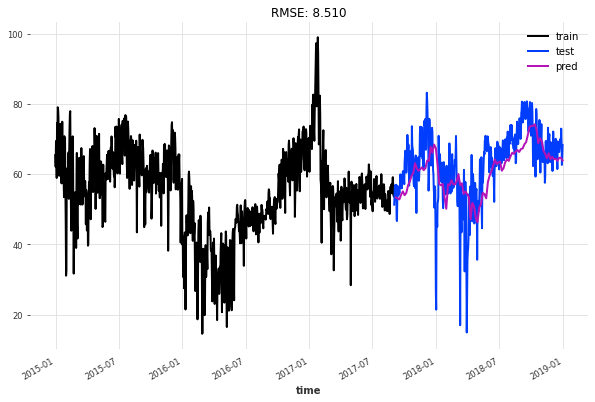

In [ ]:
plt.figure(figsize=(10,6))
results=results.append(pd.DataFrame({'Modèle' : ['NBeats'],
  'RMSE':[rmse_nb],'Training_time':[nbeats_elapsed_time]}),ignore_index=True)
train_inv.plot(label='train')
test_inv.plot(label='test')
scaler_en.inverse_transform(pred_series).plot(label='pred')
plt.title("RMSE: %.3f" %rmse_nb)
#plt.title("Predictions by Nbeats model")

### 2-TFT

Le Temporal Fusion Transformer (TFT), une nouvelle architecture basée sur l'attention qui combine une prévision multi-horizon haute performance avec des informations interprétables sur la dynamique temporelle. Apprendre des relations temporelles à différentes échelles, le TFT utilise des couches récurrentes pour le traitement local et des couches d'auto-attention interprétables pour apprendre les dépendances à long terme. Le TFT utilise également des composants spécialisés pour la sélection judicieuse des fonctionnalités pertinentes et une série de couches de déclenchement pour supprimer les composants inutiles, permettant de donner des performances élevées dans une large gamme de régimes. 

In [ ]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

In [ ]:
# before starting, we define some constants
num_samples =   486

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
# create year, month and integer index covariate series
training_cutoff = pd.Timestamp("20170901")
train_en, val_en = series_en.split_after(training_cutoff)
covariates = datetime_attribute_timeseries(series_en , attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series_en, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series_en.time_index,
        values=np.arange(len(series_en)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 8
start_time = time.time()
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=5,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)
my_model.fit(train_en_transformed, future_covariates=covariates_transformed, verbose=True)
tft_elapsed_time = time.time() - start_time

Training: 0it [00:00, ?it/s]

In [ ]:
backtest_series = my_model.historical_forecasts(
    series_en_transformed,
    future_covariates=covariates_transformed,
    start=train_en.end_time() + train_en.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/60 [00:00<?, ?it/s]

Predicting: 60it [00:00, ?it/s]

  2%|▏         | 1/60 [00:00<00:31,  1.86it/s]

Predicting: 60it [00:00, ?it/s]

  3%|▎         | 2/60 [00:01<00:32,  1.80it/s]

Predicting: 60it [00:00, ?it/s]

  5%|▌         | 3/60 [00:01<00:31,  1.84it/s]

Predicting: 60it [00:00, ?it/s]

  7%|▋         | 4/60 [00:02<00:29,  1.88it/s]

Predicting: 60it [00:00, ?it/s]

  8%|▊         | 5/60 [00:02<00:28,  1.90it/s]

Predicting: 60it [00:00, ?it/s]

 10%|█         | 6/60 [00:03<00:27,  1.93it/s]

Predicting: 60it [00:00, ?it/s]

 12%|█▏        | 7/60 [00:03<00:27,  1.93it/s]

Predicting: 60it [00:00, ?it/s]

 13%|█▎        | 8/60 [00:04<00:26,  1.93it/s]

Predicting: 60it [00:00, ?it/s]

 15%|█▌        | 9/60 [00:04<00:26,  1.91it/s]

Predicting: 60it [00:00, ?it/s]

 17%|█▋        | 10/60 [00:05<00:26,  1.91it/s]

Predicting: 60it [00:00, ?it/s]

 18%|█▊        | 11/60 [00:05<00:25,  1.91it/s]

Predicting: 60it [00:00, ?it/s]

 20%|██        | 12/60 [00:06<00:25,  1.92it/s]

Predicting: 60it [00:00, ?it/s]

 22%|██▏       | 13/60 [00:06<00:24,  1.92it/s]

Predicting: 60it [00:00, ?it/s]

 23%|██▎       | 14/60 [00:07<00:24,  1.90it/s]

Predicting: 60it [00:00, ?it/s]

 25%|██▌       | 15/60 [00:07<00:23,  1.88it/s]

Predicting: 60it [00:00, ?it/s]

 27%|██▋       | 16/60 [00:08<00:23,  1.89it/s]

Predicting: 60it [00:00, ?it/s]

 28%|██▊       | 17/60 [00:08<00:23,  1.87it/s]

Predicting: 60it [00:00, ?it/s]

 30%|███       | 18/60 [00:09<00:22,  1.84it/s]

Predicting: 60it [00:00, ?it/s]

 32%|███▏      | 19/60 [00:10<00:22,  1.86it/s]

Predicting: 60it [00:00, ?it/s]

 33%|███▎      | 20/60 [00:10<00:21,  1.87it/s]

Predicting: 60it [00:00, ?it/s]

 35%|███▌      | 21/60 [00:11<00:20,  1.88it/s]

Predicting: 60it [00:00, ?it/s]

 37%|███▋      | 22/60 [00:11<00:20,  1.90it/s]

Predicting: 60it [00:00, ?it/s]

 38%|███▊      | 23/60 [00:12<00:19,  1.91it/s]

Predicting: 60it [00:00, ?it/s]

 40%|████      | 24/60 [00:12<00:19,  1.89it/s]

Predicting: 60it [00:00, ?it/s]

 42%|████▏     | 25/60 [00:13<00:18,  1.90it/s]

Predicting: 60it [00:00, ?it/s]

 43%|████▎     | 26/60 [00:13<00:17,  1.90it/s]

Predicting: 60it [00:00, ?it/s]

 45%|████▌     | 27/60 [00:14<00:17,  1.89it/s]

Predicting: 60it [00:00, ?it/s]

 47%|████▋     | 28/60 [00:14<00:16,  1.89it/s]

Predicting: 60it [00:00, ?it/s]

 48%|████▊     | 29/60 [00:15<00:16,  1.89it/s]

Predicting: 60it [00:00, ?it/s]

 50%|█████     | 30/60 [00:15<00:15,  1.89it/s]

Predicting: 60it [00:00, ?it/s]

 52%|█████▏    | 31/60 [00:16<00:17,  1.67it/s]

Predicting: 60it [00:00, ?it/s]

 53%|█████▎    | 32/60 [00:17<00:18,  1.54it/s]

Predicting: 60it [00:00, ?it/s]

 55%|█████▌    | 33/60 [00:18<00:18,  1.44it/s]

Predicting: 60it [00:00, ?it/s]

 57%|█████▋    | 34/60 [00:18<00:18,  1.40it/s]

Predicting: 60it [00:00, ?it/s]

 58%|█████▊    | 35/60 [00:19<00:18,  1.38it/s]

Predicting: 60it [00:00, ?it/s]

 60%|██████    | 36/60 [00:20<00:17,  1.34it/s]

Predicting: 60it [00:00, ?it/s]

 62%|██████▏   | 37/60 [00:21<00:17,  1.30it/s]

Predicting: 60it [00:00, ?it/s]

 63%|██████▎   | 38/60 [00:22<00:17,  1.29it/s]

Predicting: 60it [00:00, ?it/s]

 65%|██████▌   | 39/60 [00:22<00:15,  1.35it/s]

Predicting: 60it [00:00, ?it/s]

 67%|██████▋   | 40/60 [00:23<00:13,  1.45it/s]

Predicting: 60it [00:00, ?it/s]

 68%|██████▊   | 41/60 [00:23<00:12,  1.54it/s]

Predicting: 60it [00:00, ?it/s]

 70%|███████   | 42/60 [00:24<00:11,  1.61it/s]

Predicting: 60it [00:00, ?it/s]

 72%|███████▏  | 43/60 [00:24<00:10,  1.69it/s]

Predicting: 60it [00:00, ?it/s]

 73%|███████▎  | 44/60 [00:25<00:09,  1.75it/s]

Predicting: 60it [00:00, ?it/s]

 75%|███████▌  | 45/60 [00:26<00:08,  1.77it/s]

Predicting: 60it [00:00, ?it/s]

 77%|███████▋  | 46/60 [00:26<00:07,  1.81it/s]

Predicting: 60it [00:00, ?it/s]

 78%|███████▊  | 47/60 [00:27<00:07,  1.83it/s]

Predicting: 60it [00:00, ?it/s]

 80%|████████  | 48/60 [00:27<00:06,  1.85it/s]

Predicting: 60it [00:00, ?it/s]

 82%|████████▏ | 49/60 [00:28<00:06,  1.83it/s]

Predicting: 60it [00:00, ?it/s]

 83%|████████▎ | 50/60 [00:28<00:05,  1.83it/s]

Predicting: 60it [00:00, ?it/s]

 85%|████████▌ | 51/60 [00:29<00:04,  1.85it/s]

Predicting: 60it [00:00, ?it/s]

 87%|████████▋ | 52/60 [00:29<00:04,  1.84it/s]

Predicting: 60it [00:00, ?it/s]

 88%|████████▊ | 53/60 [00:30<00:03,  1.84it/s]

Predicting: 60it [00:00, ?it/s]

 90%|█████████ | 54/60 [00:30<00:03,  1.85it/s]

Predicting: 60it [00:00, ?it/s]

 92%|█████████▏| 55/60 [00:31<00:02,  1.87it/s]

Predicting: 60it [00:00, ?it/s]

 93%|█████████▎| 56/60 [00:31<00:02,  1.86it/s]

Predicting: 60it [00:00, ?it/s]

 95%|█████████▌| 57/60 [00:32<00:01,  1.88it/s]

Predicting: 60it [00:00, ?it/s]

 97%|█████████▋| 58/60 [00:32<00:01,  1.88it/s]

Predicting: 60it [00:00, ?it/s]

 98%|█████████▊| 59/60 [00:33<00:00,  1.88it/s]

Predicting: 60it [00:00, ?it/s]

100%|██████████| 60/60 [00:34<00:00,  1.76it/s]


In [ ]:
rmse_tft=rmse(scaler_en.inverse_transform(concatenate(backtest_series)),scaler_en.inverse_transform(val_en_transformed))
print("tft - Root Mean Square Error (RMSE): %.3f" % rmse_tft)

tft - Root Mean Square Error (RMSE): 7.117


Text(0.5, 1.0, 'RMSE: 7.117')

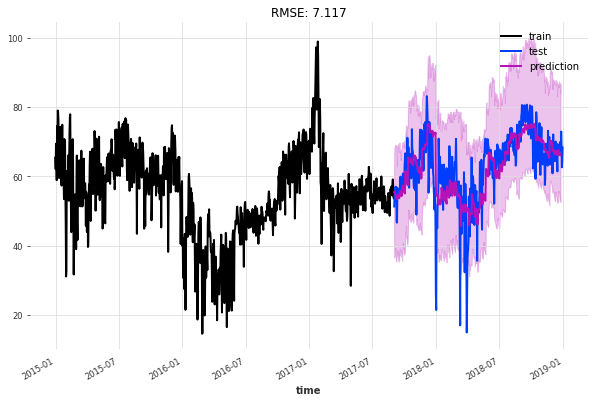

In [ ]:
results=results.append(pd.DataFrame({'Modèle' : ['TFT'],
    'RMSE':[rmse_tft],'Training_time':[tft_elapsed_time]}),ignore_index=True)
plt.figure(figsize=(10, 6))
train_inv.plot(label="train")
test_inv.plot(label="test")
scaler_en.inverse_transform(concatenate(backtest_series)).plot(label="prediction", low_quantile=0.01, high_quantile=0.99)
plt.title("RMSE: %.3f" %rmse_tft)

### 3-DeepAR

DeepAR est un réseau neuronal récurrent (RNN) qui est un type de réseau neuronal bien adapté aux données de séries chronologiques. Les RNN traitent une série chronologique étape par étape, en maintenant un état interne d'un pas de temps à l'autre.

DeepAR(RNNModel) est entièrement récurrent dans le sens où, au moment de la prédiction, une sortie est calculée à l'aide de ces entrées :

* valeur cible précédente, qui sera définie sur la dernière valeur cible connue pour la première prédiction, et pour toutes les autres prédictions, elle sera définie sur la prédiction précédente (de manière auto-régressive),

* l'état caché précédent,

* les covariables au temps t pour prévoir la cible au temps t (si le modèle a été entraîné avec des covariables),

In [ ]:
from darts.models import RNNModel
start_time = time.time()
model_en = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=16,
    input_chunk_length=10,
    likelihood=GaussianLikelihood(),
)
model_en.fit(series=train_en_transformed, future_covariates=train_moth, verbose=True)
dpr_elapsed_time = time.time() - start_time

Training: 0it [00:00, ?it/s]

In [ ]:
backtest_en = model_en.historical_forecasts(
    series=series_en_transformed,
    future_covariates=month_series,
    num_samples=100,
    start=train_en.end_time() + train_en.freq,
    forecast_horizon=8,
    stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/96 [00:00<?, ?it/s]

Predicting: 60it [00:00, ?it/s]

  1%|          | 1/96 [00:00<00:12,  7.74it/s]

Predicting: 60it [00:00, ?it/s]

  2%|▏         | 2/96 [00:00<00:12,  7.76it/s]

Predicting: 60it [00:00, ?it/s]

  3%|▎         | 3/96 [00:00<00:11,  7.86it/s]

Predicting: 60it [00:00, ?it/s]

  4%|▍         | 4/96 [00:00<00:11,  8.05it/s]

Predicting: 60it [00:00, ?it/s]

  5%|▌         | 5/96 [00:00<00:11,  7.62it/s]

Predicting: 60it [00:00, ?it/s]

  6%|▋         | 6/96 [00:00<00:11,  7.51it/s]

Predicting: 60it [00:00, ?it/s]

  7%|▋         | 7/96 [00:00<00:11,  7.50it/s]

Predicting: 60it [00:00, ?it/s]

  8%|▊         | 8/96 [00:01<00:11,  7.71it/s]

Predicting: 60it [00:00, ?it/s]

  9%|▉         | 9/96 [00:01<00:11,  7.41it/s]

Predicting: 60it [00:00, ?it/s]

 10%|█         | 10/96 [00:01<00:11,  7.56it/s]

Predicting: 60it [00:00, ?it/s]

 11%|█▏        | 11/96 [00:01<00:10,  7.79it/s]

Predicting: 60it [00:00, ?it/s]

 12%|█▎        | 12/96 [00:01<00:10,  7.92it/s]

Predicting: 60it [00:00, ?it/s]

 14%|█▎        | 13/96 [00:01<00:10,  8.06it/s]

Predicting: 60it [00:00, ?it/s]

 15%|█▍        | 14/96 [00:01<00:09,  8.20it/s]

Predicting: 60it [00:00, ?it/s]

 16%|█▌        | 15/96 [00:01<00:09,  8.14it/s]

Predicting: 60it [00:00, ?it/s]

 17%|█▋        | 16/96 [00:02<00:10,  7.90it/s]

Predicting: 60it [00:00, ?it/s]

 18%|█▊        | 17/96 [00:02<00:10,  7.74it/s]

Predicting: 60it [00:00, ?it/s]

 19%|█▉        | 18/96 [00:02<00:10,  7.64it/s]

Predicting: 60it [00:00, ?it/s]

 20%|█▉        | 19/96 [00:02<00:10,  7.40it/s]

Predicting: 60it [00:00, ?it/s]

 21%|██        | 20/96 [00:02<00:10,  7.42it/s]

Predicting: 60it [00:00, ?it/s]

 22%|██▏       | 21/96 [00:02<00:09,  7.54it/s]

Predicting: 60it [00:00, ?it/s]

 23%|██▎       | 22/96 [00:02<00:09,  7.54it/s]

Predicting: 60it [00:00, ?it/s]

 24%|██▍       | 23/96 [00:03<00:09,  7.33it/s]

Predicting: 60it [00:00, ?it/s]

 25%|██▌       | 24/96 [00:03<00:09,  7.38it/s]

Predicting: 60it [00:00, ?it/s]

 26%|██▌       | 25/96 [00:03<00:09,  7.53it/s]

Predicting: 60it [00:00, ?it/s]

 27%|██▋       | 26/96 [00:03<00:09,  7.57it/s]

Predicting: 60it [00:00, ?it/s]

 28%|██▊       | 27/96 [00:03<00:09,  7.47it/s]

Predicting: 60it [00:00, ?it/s]

 29%|██▉       | 28/96 [00:03<00:08,  7.65it/s]

Predicting: 60it [00:00, ?it/s]

 30%|███       | 29/96 [00:03<00:08,  7.77it/s]

Predicting: 60it [00:00, ?it/s]

 31%|███▏      | 30/96 [00:03<00:08,  7.83it/s]

Predicting: 60it [00:00, ?it/s]

 32%|███▏      | 31/96 [00:04<00:08,  8.07it/s]

Predicting: 60it [00:00, ?it/s]

 33%|███▎      | 32/96 [00:04<00:08,  7.86it/s]

Predicting: 60it [00:00, ?it/s]

 34%|███▍      | 33/96 [00:04<00:07,  7.96it/s]

Predicting: 60it [00:00, ?it/s]

 35%|███▌      | 34/96 [00:04<00:07,  8.01it/s]

Predicting: 60it [00:00, ?it/s]

 36%|███▋      | 35/96 [00:04<00:07,  8.13it/s]

Predicting: 60it [00:00, ?it/s]

 38%|███▊      | 36/96 [00:04<00:07,  7.92it/s]

Predicting: 60it [00:00, ?it/s]

 39%|███▊      | 37/96 [00:04<00:07,  7.68it/s]

Predicting: 60it [00:00, ?it/s]

 40%|███▉      | 38/96 [00:04<00:07,  7.46it/s]

Predicting: 60it [00:00, ?it/s]

 41%|████      | 39/96 [00:05<00:07,  7.38it/s]

Predicting: 60it [00:00, ?it/s]

 42%|████▏     | 40/96 [00:05<00:07,  7.59it/s]

Predicting: 60it [00:00, ?it/s]

 43%|████▎     | 41/96 [00:05<00:07,  7.26it/s]

Predicting: 60it [00:00, ?it/s]

 44%|████▍     | 42/96 [00:05<00:07,  7.19it/s]

Predicting: 60it [00:00, ?it/s]

 45%|████▍     | 43/96 [00:05<00:07,  7.50it/s]

Predicting: 60it [00:00, ?it/s]

 46%|████▌     | 44/96 [00:05<00:06,  7.77it/s]

Predicting: 60it [00:00, ?it/s]

 47%|████▋     | 45/96 [00:05<00:06,  7.71it/s]

Predicting: 60it [00:00, ?it/s]

 48%|████▊     | 46/96 [00:05<00:06,  7.64it/s]

Predicting: 60it [00:00, ?it/s]

 49%|████▉     | 47/96 [00:06<00:06,  7.54it/s]

Predicting: 60it [00:00, ?it/s]

 50%|█████     | 48/96 [00:06<00:06,  7.31it/s]

Predicting: 60it [00:00, ?it/s]

 51%|█████     | 49/96 [00:06<00:06,  7.42it/s]

Predicting: 60it [00:00, ?it/s]

 52%|█████▏    | 50/96 [00:06<00:06,  7.44it/s]

Predicting: 60it [00:00, ?it/s]

 53%|█████▎    | 51/96 [00:06<00:06,  7.48it/s]

Predicting: 60it [00:00, ?it/s]

 54%|█████▍    | 52/96 [00:06<00:05,  7.37it/s]

Predicting: 60it [00:00, ?it/s]

 55%|█████▌    | 53/96 [00:06<00:05,  7.42it/s]

Predicting: 60it [00:00, ?it/s]

 56%|█████▋    | 54/96 [00:07<00:05,  7.40it/s]

Predicting: 60it [00:00, ?it/s]

 57%|█████▋    | 55/96 [00:07<00:05,  7.15it/s]

Predicting: 60it [00:00, ?it/s]

 58%|█████▊    | 56/96 [00:07<00:05,  7.12it/s]

Predicting: 60it [00:00, ?it/s]

 59%|█████▉    | 57/96 [00:07<00:05,  7.16it/s]

Predicting: 60it [00:00, ?it/s]

 60%|██████    | 58/96 [00:07<00:05,  7.21it/s]

Predicting: 60it [00:00, ?it/s]

 61%|██████▏   | 59/96 [00:07<00:05,  7.38it/s]

Predicting: 60it [00:00, ?it/s]

 62%|██████▎   | 60/96 [00:07<00:04,  7.62it/s]

Predicting: 60it [00:00, ?it/s]

 64%|██████▎   | 61/96 [00:08<00:04,  7.65it/s]

Predicting: 60it [00:00, ?it/s]

 65%|██████▍   | 62/96 [00:08<00:04,  7.57it/s]

Predicting: 60it [00:00, ?it/s]

 66%|██████▌   | 63/96 [00:08<00:04,  7.54it/s]

Predicting: 60it [00:00, ?it/s]

 67%|██████▋   | 64/96 [00:08<00:04,  7.39it/s]

Predicting: 60it [00:00, ?it/s]

 68%|██████▊   | 65/96 [00:08<00:04,  7.47it/s]

Predicting: 60it [00:00, ?it/s]

 69%|██████▉   | 66/96 [00:08<00:03,  7.67it/s]

Predicting: 60it [00:00, ?it/s]

 70%|██████▉   | 67/96 [00:08<00:03,  7.61it/s]

Predicting: 60it [00:00, ?it/s]

 71%|███████   | 68/96 [00:08<00:03,  7.60it/s]

Predicting: 60it [00:00, ?it/s]

 72%|███████▏  | 69/96 [00:09<00:03,  7.57it/s]

Predicting: 60it [00:00, ?it/s]

 73%|███████▎  | 70/96 [00:09<00:03,  7.58it/s]

Predicting: 60it [00:00, ?it/s]

 74%|███████▍  | 71/96 [00:09<00:03,  7.52it/s]

Predicting: 60it [00:00, ?it/s]

 75%|███████▌  | 72/96 [00:09<00:03,  7.28it/s]

Predicting: 60it [00:00, ?it/s]

 76%|███████▌  | 73/96 [00:09<00:03,  7.08it/s]

Predicting: 60it [00:00, ?it/s]

 77%|███████▋  | 74/96 [00:09<00:03,  7.20it/s]

Predicting: 60it [00:00, ?it/s]

 78%|███████▊  | 75/96 [00:09<00:02,  7.15it/s]

Predicting: 60it [00:00, ?it/s]

 79%|███████▉  | 76/96 [00:10<00:02,  7.30it/s]

Predicting: 60it [00:00, ?it/s]

 80%|████████  | 77/96 [00:10<00:02,  7.44it/s]

Predicting: 60it [00:00, ?it/s]

 81%|████████▏ | 78/96 [00:10<00:02,  7.49it/s]

Predicting: 60it [00:00, ?it/s]

 82%|████████▏ | 79/96 [00:10<00:02,  7.36it/s]

Predicting: 60it [00:00, ?it/s]

 83%|████████▎ | 80/96 [00:10<00:02,  7.31it/s]

Predicting: 60it [00:00, ?it/s]

 84%|████████▍ | 81/96 [00:10<00:02,  7.29it/s]

Predicting: 60it [00:00, ?it/s]

 85%|████████▌ | 82/96 [00:10<00:01,  7.23it/s]

Predicting: 60it [00:00, ?it/s]

 86%|████████▋ | 83/96 [00:11<00:01,  7.24it/s]

Predicting: 60it [00:00, ?it/s]

 88%|████████▊ | 84/96 [00:11<00:01,  7.36it/s]

Predicting: 60it [00:00, ?it/s]

 89%|████████▊ | 85/96 [00:11<00:01,  7.30it/s]

Predicting: 60it [00:00, ?it/s]

 90%|████████▉ | 86/96 [00:11<00:01,  7.29it/s]

Predicting: 60it [00:00, ?it/s]

 91%|█████████ | 87/96 [00:11<00:01,  7.15it/s]

Predicting: 60it [00:00, ?it/s]

 92%|█████████▏| 88/96 [00:11<00:01,  7.23it/s]

Predicting: 60it [00:00, ?it/s]

 93%|█████████▎| 89/96 [00:11<00:00,  7.36it/s]

Predicting: 60it [00:00, ?it/s]

 94%|█████████▍| 90/96 [00:11<00:00,  7.41it/s]

Predicting: 60it [00:00, ?it/s]

 95%|█████████▍| 91/96 [00:12<00:00,  7.42it/s]

Predicting: 60it [00:00, ?it/s]

 96%|█████████▌| 92/96 [00:12<00:00,  7.40it/s]

Predicting: 60it [00:00, ?it/s]

 97%|█████████▋| 93/96 [00:12<00:00,  7.51it/s]

Predicting: 60it [00:00, ?it/s]

 98%|█████████▊| 94/96 [00:12<00:00,  7.76it/s]

Predicting: 60it [00:00, ?it/s]

 99%|█████████▉| 95/96 [00:12<00:00,  7.61it/s]

Predicting: 60it [00:00, ?it/s]

100%|██████████| 96/96 [00:12<00:00,  7.52it/s]


In [ ]:
rmse_dar =rmse(scaler_en.inverse_transform(backtest_en),scaler_en.inverse_transform(val_en_transformed))
print("DeepAR - Root Mean Square Error (RMSE): %.3f" % rmse_dar)

DeepAR - Root Mean Square Error (RMSE): 6.195


Text(0.5, 1.0, 'RMSE: 6.195')

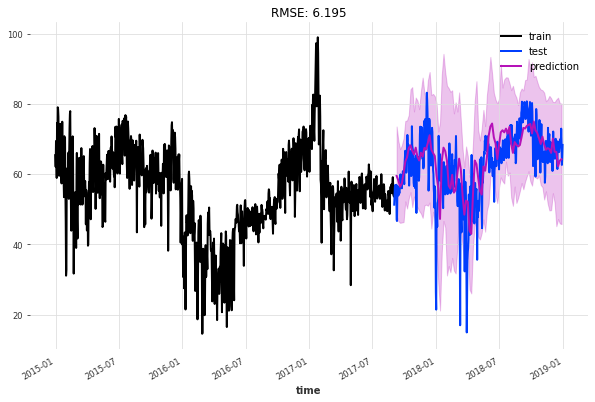

In [ ]:
results=results.append(pd.DataFrame({'Modèle' : ['DeepAR'],
    'RMSE':[rmse_dar],'Training_time':[dpr_elapsed_time]}),ignore_index=True)
plt.figure(figsize=(10, 6))
train_inv.plot(label="train")
test_inv.plot(label="test")
scaler_en.inverse_transform(backtest_en).plot(label="prediction", low_quantile=0.01, high_quantile=0.99)
plt.title("RMSE: %.3f" %rmse_dar)

## Bilan des modèles

In [ ]:
results=results.drop_duplicates(subset=['Modèle'])
results

Modèle       RMSE  Training_time
0  FPROPHET  30.507053       0.262511
1   XGBoost   6.416534       0.541170
2     TBATS  13.030874      42.681676
4    NBeats   8.510379      21.736298
5       TFT   7.116940      23.739106
7    DeepAR   6.195211      15.736126

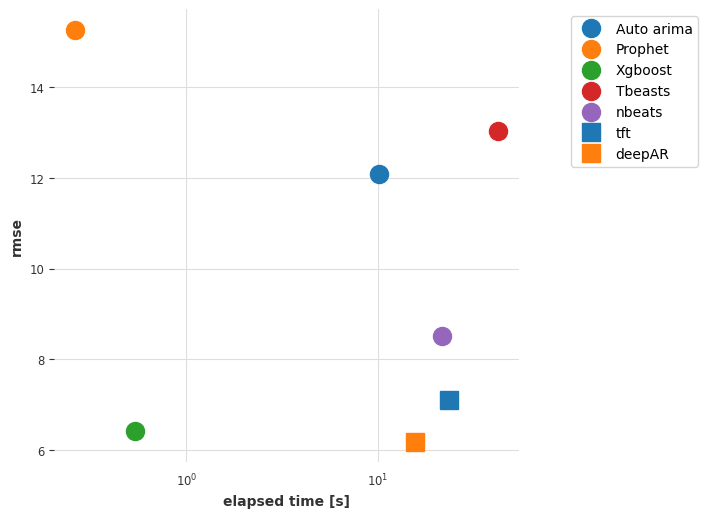

In [ ]:
smapes = {'Auto arima': rmse_aarima ,
    'Prophet': rmse_fb/2,# rmse=rmse/2
    'Xgboost': rmse_xgb,
    'Tbeasts': rmse_tbats,
    'nbeats': rmse_nb ,
    'tft': rmse_tft,
    'deepAR': rmse_dar}

elapsed_times = {'Auto arima': aarima_elapsed_time ,
    'Prophet': fb_elapsed_time,
    'Xgboost': xgb_elapsed_time,
    'Tbeasts': tbats_elapsed_time,
    'nbeats': nbeats_elapsed_time,
    'tft': tft_elapsed_time,
    'deepAR': dpr_elapsed_time}

plot_models_result(elapsed_times, smapes)

##<a>Sources

- https://github.com/unit8co/darts
- https://paperswithcode.com/paper/deepar-probabilistic-forecasting-with 
- https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285
- https://www.deepdetect.com/blog/11-ts-forecast-nbeats/
-https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9